In [1]:
import pandas as pd

import plotly.express as px
from dash import Dash, dcc, html

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import os


from rapidfuzz import fuzz
from itertools import combinations

In [30]:
from src.constants import AFRICAN_COUNTRIES, START_DATE, END_DATE
from src.data_loader import get_combined_data, data_preprocessing, DATA_DIR

In [31]:
df = get_combined_data()
df.head()

/Users/luke-liambergmeier/Desktop/africa_conflict/src/data_loader.py:110: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  ucdp_df = pd.read_csv(ucdp_path)
/Users/luke-liambergmeier/Desktop/africa_conflict/src/data_loader.py:150: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  acled_std.loc[:,"event_date"] = pd.to_datetime(acled_std["event_date"], errors='coerce')


,event_id_cnty,event_date,year,time_precision,disorder_type,actor1,actor2,actor1_id,actor2_id,latitude,...,admin2,location,country,region,geo_precision,fatalities,notes,source,source_dataset,time_precision_text
0,DRC31402,2023-12-31 00:00:00,2023,1,Political violence,Rioters (Democratic Republic of Congo),NaN,Rioters (Democratic Republic of Congo),NaN,-6.1500,...,Mbuji-Mayi,Mbuji-Mayi,Democratic Republic of Congo,Middle Africa,1,0,"On 31 December 2023, rioters burnt and ransack...",7 Sur 7; Election-Net; Radio Okapi; Twitter,ACLED,day
1,BFO11325,2023-12-31 00:00:00,2023,1,Political violence,JNIM: Group for Support of Islam and Muslims,NaN,JNIM: Group for Support of Islam and Muslims,NaN,12.9871,...,Gnagna,Badore,Burkina Faso,Western Africa,1,0,"On 31 December 2023, a cattle hit an IED likel...",Facebook,ACLED,day
2,BFO11326,2023-12-31 00:00:00,2023,1,Political violence,JNIM: Group for Support of Islam and Muslims,Military Forces of Burkina Faso (2022-),JNIM: Group for Support of Islam and Muslims,Military Forces of Burkina Faso (2022-),13.4417,...,Yagha,Sebba,Burkina Faso,Western Africa,1,0,"On 31 December 2023, suspected JNIM militants ...",Whatsapp,ACLED,day
3,GAB472,2023-12-31 00:00:00,2023,2,Demonstrations,Protesters (Gabon),NaN,Protesters (Gabon),NaN,0.3901,...,Libreville,Libreville,Gabon,Middle Africa,1,0,"Around 31 December 2023 (as reported), ex-work...",Gabon Actu,ACLED,week
4,GHA2083,2023-12-31 00:00:00,2023,2,Political violence,Rioters (Ghana),NaN,Rioters (Ghana),NaN,7.7254,...,Kadjebi,Dodi Papase,Ghana,Western Africa,1,0,"Around 31 December 2023 (as reported), youths ...",Ghana Web,ACLED,week


In [4]:
df.columns

Index(['event_id_cnty', 'event_date', 'year', 'time_precision',
       'disorder_type', 'actor1', 'actor2', 'actor1_id', 'actor2_id',
       'latitude', 'longitude', 'admin1', 'admin2', 'location', 'country',
       'region', 'geo_precision', 'fatalities', 'notes', 'source',
       'source_dataset', 'time_precision_text'],
      dtype='object')

Filter for Africa and 1997-2023

In [32]:
df = data_preprocessing(df)

### Checking the merged dataset for sanity & anomilies

In [33]:
#Entries
print("Amount of rows")
print(len(df))

#Missing Values
print("\nMissing values per column:")
print(df.isnull().sum())

#Checking for dublicates
print("\nDuplicates in dataset: ", df.duplicated().sum())

# Is event_id_cnty primary key?
print("\nDuplicated event_id_cnty entries: ", df['event_id_cnty'].duplicated().sum())

# Year row matches date?
df['event_date'] = pd.to_datetime(df['event_date'])
invalid_years = (df['event_date'].dt.year != df['year']).sum()
print("Rows where event_date year does not match 'year' column: ", invalid_years)

# time_precision entries count
print("\ntime_precision value counts:")
combined_counts = pd.concat([
    df['time_precision'].value_counts().sort_index(),
    df['time_precision_text'].value_counts().sort_index()
], axis=1, keys=['time_precision', 'time_precision_text'])

print(combined_counts.fillna(0).astype(int))

# Latitude and longitude check
invalid_lat = df[(df['latitude'] < -90) | (df['latitude'] > 90)]
invalid_lon = df[(df['longitude'] < -180) | (df['longitude'] > 180)]
print("\nInvalid latitude entries:", len(invalid_lat))
print("Invalid longitude entries:", len(invalid_lon))

# Fatalities checks
print("\nFatalities summary statistics:")
print(df['fatalities'].describe())

# Fatalities checks
print("\nFatalities summary statistics:")
print(df['disorder_type'].value_counts())

print("\nNegative fatalities entries:")
print(df[df['fatalities'] < 0])

# Country and region checks
print("List of all countries by count")
print(df['country'].value_counts())

# Source dataset check
print("\nsource_dataset value counts:")
print(df['source_dataset'].value_counts(dropna=False))

print("\nRows with missing source_dataset:")
print(df['source_dataset'].isnull().sum())

Amount of rows
397938

Missing values per column:
event_id_cnty              0
event_date                 0
year                       0
time_precision             0
disorder_type              0
actor1                     0
actor2                 93836
actor1_id                  0
actor2_id                  0
latitude                   0
longitude                  0
admin1                   726
admin2                 10392
location                 935
country                    0
region                     0
geo_precision              0
fatalities                 0
notes                      0
source                 12135
source_dataset             0
time_precision_text        0
month                      0
month_year                 0
dyad                       0
dtype: int64

Duplicates in dataset:  0

Duplicated event_id_cnty entries:  0
Rows where event_date year does not match 'year' column:  0

time_precision value counts:
      time_precision  time_precision_text
1             3

Visualisation of Sanity Check

In [25]:
summary = []

for col in df.columns:
    col_data = df[col]
    col_summary = {
        'column': col,
        'dtype': col_data.dtype,
        'missing_values': col_data.isna().sum()
    }

    if pd.api.types.is_numeric_dtype(col_data):
        col_summary['min'] = col_data.min()
        col_summary['max'] = col_data.max()
    elif pd.api.types.is_datetime64_any_dtype(col_data):
        col_summary['min'] = col_data.min()
        col_summary['max'] = col_data.max()
    else:
        col_summary['min'] = None
        col_summary['max'] = None

    summary.append(col_summary)

# Create DataFrame
summary_df = pd.DataFrame(summary)
print(summary_df)

                 column           dtype  missing_values                  min  \
0         event_id_cnty          object               0                 None   
1            event_date          object               0                 None   
2                  year           int64               0                 1997   
3        time_precision           int64               0                    1   
4         disorder_type          object               0                 None   
5                actor1          object               0                 None   
6                actor2          object           93836                 None   
7             actor1_id          object               0                 None   
8             actor2_id          object               0                 None   
9              latitude         float64               0             -34.7068   
10            longitude         float64               0             -25.1631   
11               admin1          object 

### Analysis of different Actors

In [25]:
df_actor = df.loc[:, ['actor1', 'actor2']]
all_actors = df_actor.stack().dropna().astype(str).reset_index(drop=True)
names_and_frequency = pd.DataFrame(all_actors, columns=['actor']).groupby('actor').size()
names = all_actors.unique().tolist()

print(f"\nTotal unique actors: {len(names)}")

threshold = 90

matches = []
for i, j in combinations(range(len(names)), 2):
    score = fuzz.token_sort_ratio(names[i], names[j])
    if score >= threshold:
        matches.append((names[i], names[j], score))

similar_df = pd.DataFrame(matches, columns=['name1', 'name2', 'similarity'])


Total unique actors: 8441


In [26]:
similar_df.loc[:,'frequency_name1'] = similar_df.loc[:,'name1'].map(names_and_frequency)
similar_df.loc[:,'frequency_name2'] = similar_df.loc[:,'name2'].map(names_and_frequency)

In [27]:
similar_df

,name1,name2,similarity,frequency_name1,frequency_name2
0,Military Forces of Burkina Faso (2022-),Military Forces of Burkina Faso (2015-2022),92.682927,1227,963
1,Military Forces of Burkina Faso (2022-),Military Forces of Burkina Faso (2014-2015),90.243902,1227,6
2,Protesters (Mali),Protesters (Malawi),94.444444,704,542
3,Military Forces of Mali (2021-),Military Forces of Malawi (2020-),93.750000,1336,5
4,Military Forces of Mali (2021-),Military Forces of Mali (2020-2021),90.909091,1336,112
...,...,...,...,...,...
18481,Luway subclan of Mirifle clan (Digil-Mirifle),Huber subclan of Mirifle clan (Digil-Mirifle),91.111111,8,3
18482,Abdalleh-Agon-Yar subclan of Abgal clan (Hawiye),Abdalle-Aroneh subclan of Abgal clan (Hawiye),90.322581,4,1
18483,Eli-Agon-Yar subclan of Abgal clan (Hawiye),Eli-Omar subclan of Abgal clan (Hawiye),90.243902,4,1
18484,SLM/A - MM,SLM/A - MA,90.000000,27,4


In [28]:
df_acled_actor = df.loc[df['source_dataset'] == 'ACLED', ['actor1', 'actor2']]
all_acled_actors = df_acled_actor.stack().dropna().astype(str)
unique_acled_actors = all_acled_actors.unique().tolist()

df_ucdp_actor = df.loc[df['source_dataset'] == 'UCDP', ['actor1', 'actor2']]
all_ucdp_actors = df_ucdp_actor.stack().dropna().astype(str)
unique_ucdp_actors = all_ucdp_actors.unique().tolist()

name_matching_ucdp_acled = similar_df[
    (
        similar_df['name1'].isin(unique_acled_actors) & similar_df['name2'].isin(unique_ucdp_actors)
    ) | (
        similar_df['name2'].isin(unique_acled_actors) & similar_df['name1'].isin(unique_ucdp_actors)
    )
]

print(len(df))
print(sum(name_matching_ucdp_acled['frequency_name1'])+sum(name_matching_ucdp_acled['frequency_name2']))

397938
9340


In [29]:
name_matching_ucdp_acled.sort_values('frequency_name1', ascending=False)

,name1,name2,similarity,frequency_name1,frequency_name2
342,Government of Nigeria,Government of Liberia,90.47619,3281,68
343,Government of Nigeria,Government of Niger,95.00000,3281,279
2673,Government of Uganda,Government of Rwanda,90.00000,1136,546
13334,Government of Liberia,Government of Libya,90.00000,68,681


### Looking at some stats

<Axes: title={'center': 'country'}>

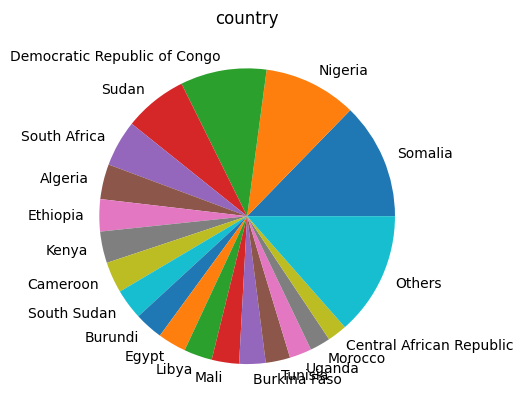

In [13]:
counts = df['country'].value_counts()
pct = counts / counts.sum()
others = pct[pct < 0.02].sum()
main = pct[pct >= 0.02]
country_overview = pd.concat([main, pd.Series({'Others': others})])
country_overview.plot(kind="pie", title = 'country')

<Axes: title={'center': 'Disorder Type'}, ylabel='count'>

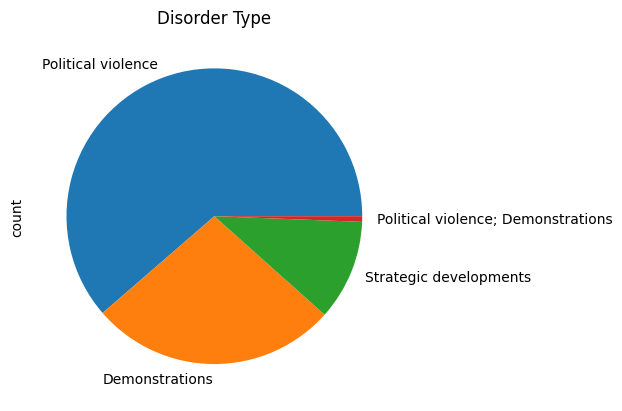

In [14]:
df['disorder_type'].value_counts().plot(kind="pie", title='Disorder Type')

In [15]:
df_acled = df.loc[df['source_dataset'] == 'ACLED', :]
df_ucdp = df.loc[df['source_dataset'] == 'UCDP', :]
print('Number of NAs in source: ' + str(df['source'].isna().sum()) + ' out of dataset with len ' + str(len(df)))
grouped_source_data = (
    df.loc[df['source'].isin(df_ucdp['source']) & df['source'].isin(df_acled['source']),:]
    .groupby(['source'])
    .agg({
        'source_dataset': lambda x: list(set(x)),
        'event_id_cnty': 'size'
    })
).rename(columns={'source_dataset':'present_in_dataset','event_id_cnty':'count'})

grouped_source_data.sort_values('count', ascending=False)

Number of NAs in source: 12135 out of dataset with len 397938


,present_in_dataset,count
source,,
AFP,"[ACLED, UCDP]",10531
All Africa,"[ACLED, UCDP]",9510
Radio Dabanga,"[ACLED, UCDP]",8254
Radio Okapi,"[ACLED, UCDP]",7115
Kivu Security Tracker,"[ACLED, UCDP]",6250
...,...,...
Burundi Human Rights Initiative,"[ACLED, UCDP]",4
African Union,"[ACLED, UCDP]",3
Intelligence Briefs,"[ACLED, UCDP]",2


In [16]:
print('Number of NAs in source: ' + str(df['notes'].isna().sum()) + ' out of dataset with len ' + str(len(df)))
df['max_note_length'] = df['notes'].fillna('').apply(len)
grouped_notes_data = (
    df
    .groupby([df['max_note_length'] // 20 * 20 + 20, 'source_dataset'])
    .agg({
        #'source_dataset': lambda x: list(set(x)),
        'event_id_cnty': 'size',
        'notes': 'first',
    })
).rename(columns={'source_dataset':'present_in_dataset','event_id_cnty':'count', 'notes': 'example note'}).reset_index()

print(sum(grouped_notes_data.loc[grouped_notes_data['max_note_length']>=300,'count']))
grouped_notes_data.sort_values('max_note_length')

Number of NAs in source: 0 out of dataset with len 397938
68178


,max_note_length,source_dataset,count,example note
0,20,ACLED,1594,RRR left the city.
1,20,UCDP,1327,Reuters 29-sep-04
2,40,ACLED,6159,Armed men killed two couples.
3,40,UCDP,1867,"Algerian newspaper Le Matin, 17-mar-04"
4,60,ACLED,10810,"On 21 January 2020, FARDC soldiers killed a ma..."
...,...,...,...,...
186,2780,UCDP,1,"""All Africa,2015-12-15,Former Minister On Tria..."
187,3020,UCDP,1,"""Agence France Presse,2022-08-22,Somalia PM vo..."
188,3040,UCDP,1,"""dpa International Service in English,2017-05-..."
189,3080,UCDP,1,"""Tahrir Institute for Middle East Policy,2018-..."


<Axes: xlabel='year'>

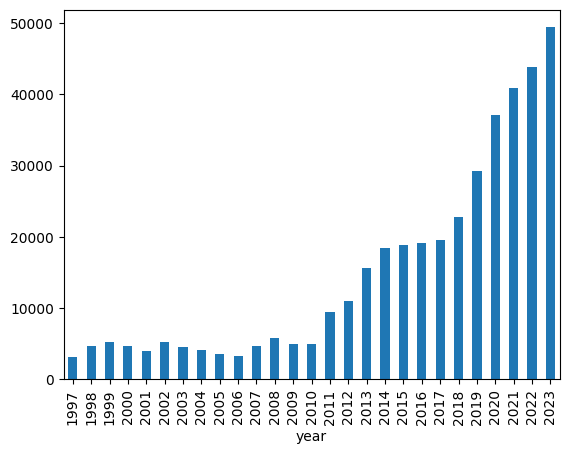

In [17]:
df['year'].value_counts().sort_index().plot(kind="bar")

<Axes: xlabel='year'>

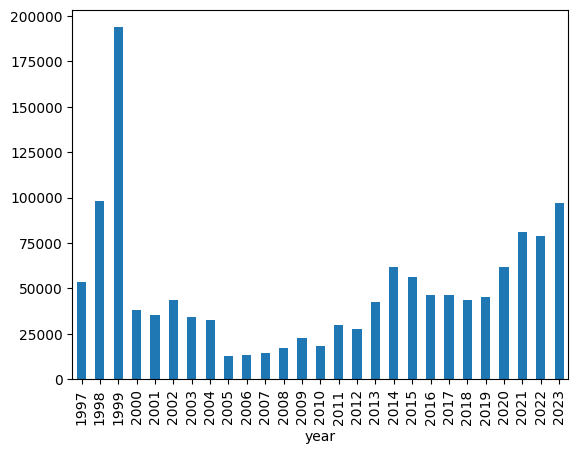

In [18]:
df.groupby('year')['fatalities'].sum().sort_index().plot(kind="bar")

In [19]:
# usefull stats
sum_death = df.groupby('location')['fatalities'].sum()
df.loc[:,'frequency'] = df.loc[:,'location'].map(sum_death)
median_no_death_over_locations = df.frequency.median()
std_no_of_death_over_locations = df.frequency.std()
df.loc[:,'z_scores'] = (df.loc[:,'frequency'] - median_no_death_over_locations) / std_no_of_death_over_locations

In [20]:
# Precompute frequency per year
def preprocess_year(df, year):
    df_year = df[df['year'] == year].copy()
    no_death = df_year.groupby('location')['fatalities'].sum()
    df_year.loc[:,'frequency_year'] = df['location'].map(no_death)
    df_year.loc[:,'z_scores'] = (df_year['frequency_year'] - median_no_death_over_locations) / std_no_of_death_over_locations
    return df_year[df_year['z_scores'] > 0]

# Unique years
years = sorted(df['year'].unique())

# Dash App
app = Dash(__name__)
app.layout = html.Div([
    html.H1("Conflict Hotspots in Africa by Year"),
    dcc.Slider(
        min=min(years),
        max=max(years),
        step=1,
        marks={str(year): str(year) for year in years},
        value=min(years),
        id='year-slider'
    ),
    html.Div([
        dcc.Graph(id='heatmap'),
        dcc.Graph(id='zoomed-heatmap')
    ], style={'display': 'flex', 'flexDirection': 'row'})
])

from dash.dependencies import Output, Input

@app.callback(
    Output('heatmap', 'figure'),
    Output('zoomed-heatmap', 'figure'),
    Input('year-slider', 'value')
)
def update_maps(selected_year):
    df_filtered = preprocess_year(df, selected_year)

    # Global heatmap
    fig_global = px.density_mapbox(
        df_filtered,
        lat='latitude',
        lon='longitude',
        z='z_scores',
        radius=15,
        center=dict(lat=df['latitude'].mean(), lon=df['longitude'].mean()),
        zoom=1,
        mapbox_style="carto-positron",
        title=f"Conflict Hotspots - {selected_year} (Global View)"
    )

    # Zoomed-in heatmap - find densest point
    top_location = df_filtered.groupby(['latitude', 'longitude'])['z_scores'].mean().idxmax()
    center_lat, center_lon = top_location

    fig_zoomed = px.density_mapbox(
        df_filtered,
        lat='latitude',
        lon='longitude',
        z='z_scores',
        radius=15,
        center=dict(lat=center_lat, lon=center_lon),
        zoom=4,  
        mapbox_style="carto-positron",
        title=f"Conflict Hotspots - {selected_year} (Zoomed View)"
    )

    return fig_global, fig_zoomed

if __name__ == '__main__':
    app.run(debug=True)


/var/folders/g0/xfp53vy55xs46l_byzw6zwq40000gn/T/ipykernel_40285/1424282955.py:41: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/var/folders/g0/xfp53vy55xs46l_byzw6zwq40000gn/T/ipykernel_40285/1424282955.py:57: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [21]:
df.loc[:,'date'] = pd.to_datetime(df['event_date'], errors='coerce')


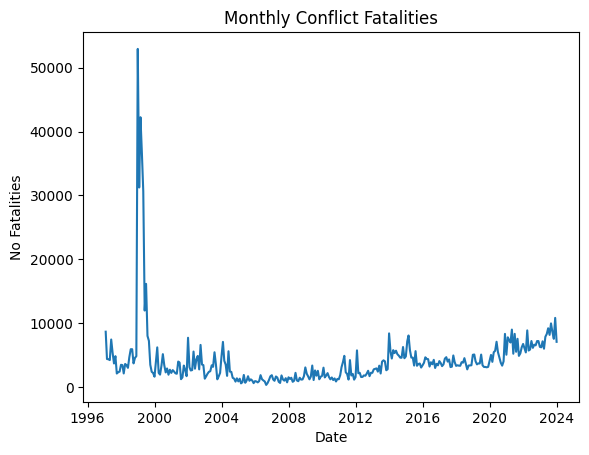

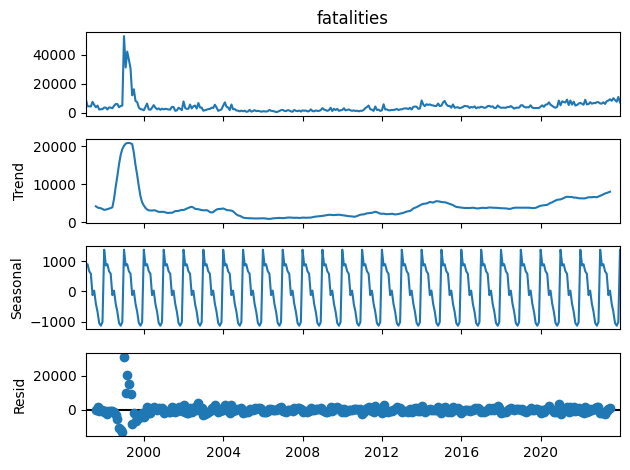

In [22]:
conflict_ts = df.groupby('date')['fatalities'].sum().sort_index()

# 'M' for monthly
monthly_counts = conflict_ts.resample('ME').sum()

# Plot resampled time series
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values)
plt.title("Monthly Conflict Fatalities")
plt.xlabel("Date")
plt.ylabel("No Fatalities")
plt.show()

# Decompose
decompose = seasonal_decompose(monthly_counts, model='additive', period=12) 
decompose.plot()
plt.show()


4152.101851851852
328
52931


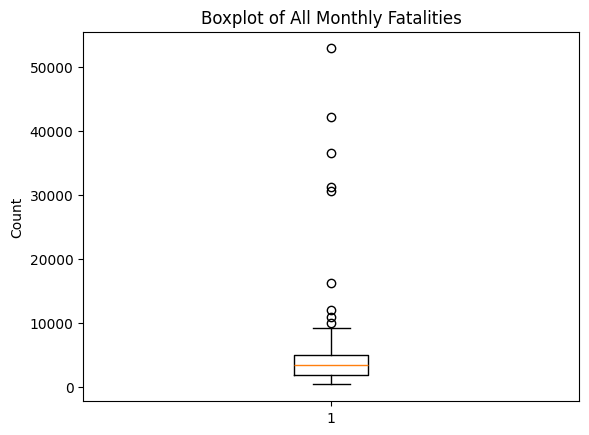

In [23]:
print(monthly_counts.values.mean())
print(monthly_counts.values.min())
print(monthly_counts.values.max())

# Boxplot of all values
plt.boxplot(monthly_counts.values)
plt.title("Boxplot of All Monthly Fatalities")
plt.ylabel("Count")
plt.show()

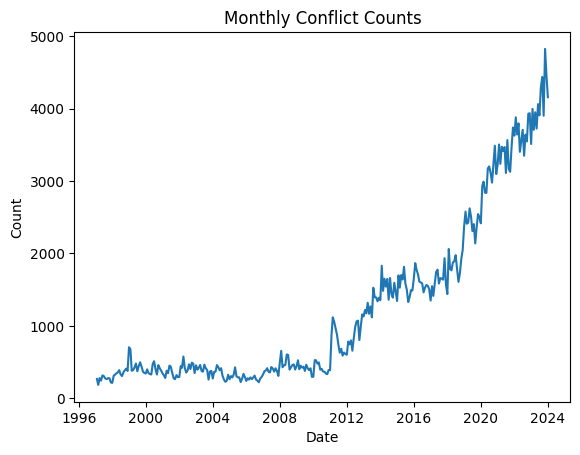

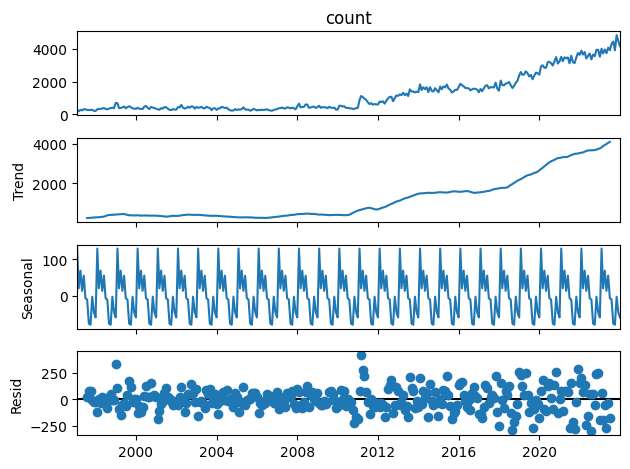

In [24]:
conflict_ts = df.date.value_counts().sort_index()

# 'M' for monthly
monthly_counts = conflict_ts.resample('ME').sum()

# Plot resampled time series
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values)
plt.title("Monthly Conflict Counts")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

# Decompose
decompose = seasonal_decompose(monthly_counts, model='additive', period=12) 
decompose.plot()
plt.show()